
Simulation-based Inference (SBI; https://github.com/sbi-dev/sbi) on a Mean-Field Model (MFM) of spiking neurons, developed by Montbrio et al., PRX 2015 (see https://arxiv.org/pdf/1506.06581.pdf). 


In this notebook, we consider an ODE form of equations with Step input current, and we train SNPE (with a single of round; amortized) to infer the posterior of model parameters from low-dimentional data features.  

In this notebook, we save the simulations and features in two steps, to be more flexible with training. Navertheless, it takes more memory to load the simuations, but one can refer to DataLoader of batched parameters-observation pairs (see LAMPE; https://lampe.readthedocs.io/en/stable/index.html) 

For more details see Gonçalves et al., elife 2020 and Hashemi et al., Neural Networks 2023. For installation of SBI see: https://github.com/sbi-dev/sbi


In [1]:
import os
import sys
import time
import errno

import numpy as np
import scipy as scp
import pandas as pd
import seaborn as sns

In [2]:
import numba
from numba import jit

In [3]:
import torch
import sbi

import sbi.inference
from sbi.inference import SNPE, prepare_for_sbi ,simulate_for_sbi, DirectPosterior
from sbi.inference.base import infer

from sbi.analysis import ActiveSubspace, pairplot
import sbi.utils as utils

In [4]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [5]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [6]:
%pylab inline
#%matplotlib notebook

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/meysam/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['cast']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [7]:
print(f"Numpy version: {np.__version__}")
print(f"Numba version: {numba.__version__}")
print(f"Matplotlib` version: {matplotlib.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"SciPy version: {scp.__version__}")
print(f"SBI version: {sbi.__version__}")

Numpy version: 1.24.4
Numba version: 0.57.1
Matplotlib` version: 3.7.1
Pandas version: 2.0.2
SciPy version: 1.10.1
SBI version: 0.21.0


In [8]:
cwd = os.getcwd()
cwd

'/mnt/0582b5ea-dc43-4c17-8a69-29b39f3fc394/SBI/MPR_NMM_SBI'

In [9]:
Res_dir='Res_sbi_ode_features_dejasim'

In [10]:
import warnings
warnings.filterwarnings("ignore")

# Simulation of Montbrio model


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $


In [11]:
def Montbrio_ODEmodel(params, constants, I_input, dt, ts):
   
    #parameters
    delta, eta, J  = params[0], params[1], params[2]

    dt = float(dt) #Euler inetgration

    # simulation from initial point
    v = np.zeros_like(ts)  # membrane potential
    r = np.zeros_like(ts)  # firing rate

    # fixed parameters (initial conditions)
    v_init, r_init=constants[0], constants[1]
    v[0],r[0]= v_init, r_init

    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv 
        r[i]=r[i-1] + dt * dr  
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))
     

In [12]:
Montbrio_ODEmodel_numba = numba.jit(Montbrio_ODEmodel)

In [13]:
# set the model key parameters that we aim to infer 

delta=0.7
eta=-4.6
J=14.5

params=[delta, eta, J]

In [14]:
# set the initial and final times, and time steps for euler integration

t_init = 0.0
t_final = 100.0

dt = 0.001
ts = np.arange(t_init,t_final,dt)

nt=ts.shape[0]

In [15]:
# Set the parameters of input current

I0=3.
t_on=30.
t_off=60.

I_input=[]
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input =np.asarray(I_input)

In [16]:
# set the initial conditions as constants

v0 = -3.0
r0 = 0.5

constants=[v0, r0]

In [17]:
start_time = time.time()

rv = Montbrio_ODEmodel(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 0.19935178756713867 seconds ---


In [18]:
## first run using JIT numba takes time due to compilation, but then in is in fly!

In [19]:
start_time = time.time()

rv = Montbrio_ODEmodel_numba(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 1.2455432415008545 seconds ---


In [20]:
start_time = time.time()

rv = Montbrio_ODEmodel_numba(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 0.0018486976623535156 seconds ---


In [21]:
v=rv[0:nt]
r=rv[nt:2*nt]

ts.shape, v.shape, r.shape

((100000,), (100000,), (100000,))

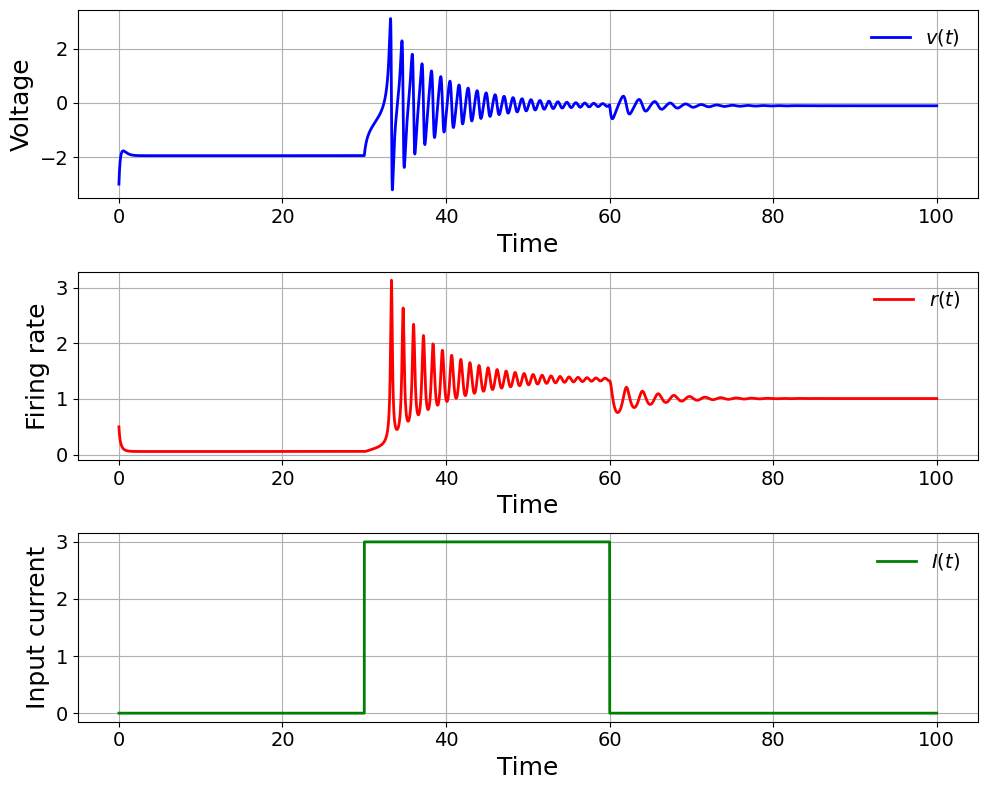

In [22]:
plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(ts, v, 'b', linewidth=2, label='$v(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Voltage', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

plt.subplot(312)
plt.plot(ts, r, 'r', linewidth=2, label='$r(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Firing rate', fontsize=18); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(313)
plt.plot(ts, I_input, 'g', linewidth=2, label='$I(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Input current', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep.png"), dpi=300)
plt.show()

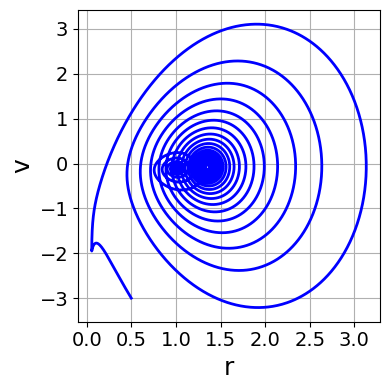

In [23]:
plt.figure(figsize=(4, 4))
plt.plot(r, v, 'b', linewidth=2)
plt.ylabel('v', fontsize=18); 
plt.xlabel('r', fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

# Extract data Features

we focus on the summary statistics (mean, std, median, skew, kurtosis) as well as the peaks.

In [24]:
from scipy.signal import  find_peaks

In [25]:
v_act=v[(ts > t_on) & (ts < t_off)]
peaks_act, _ = find_peaks(v_act, height=.2, distance=1000)
peaks_act

array([ 3209,  4610,  5867,  7061,  8218,  9354, 10475, 11588, 12695,
       13798, 14898, 15997, 17094])

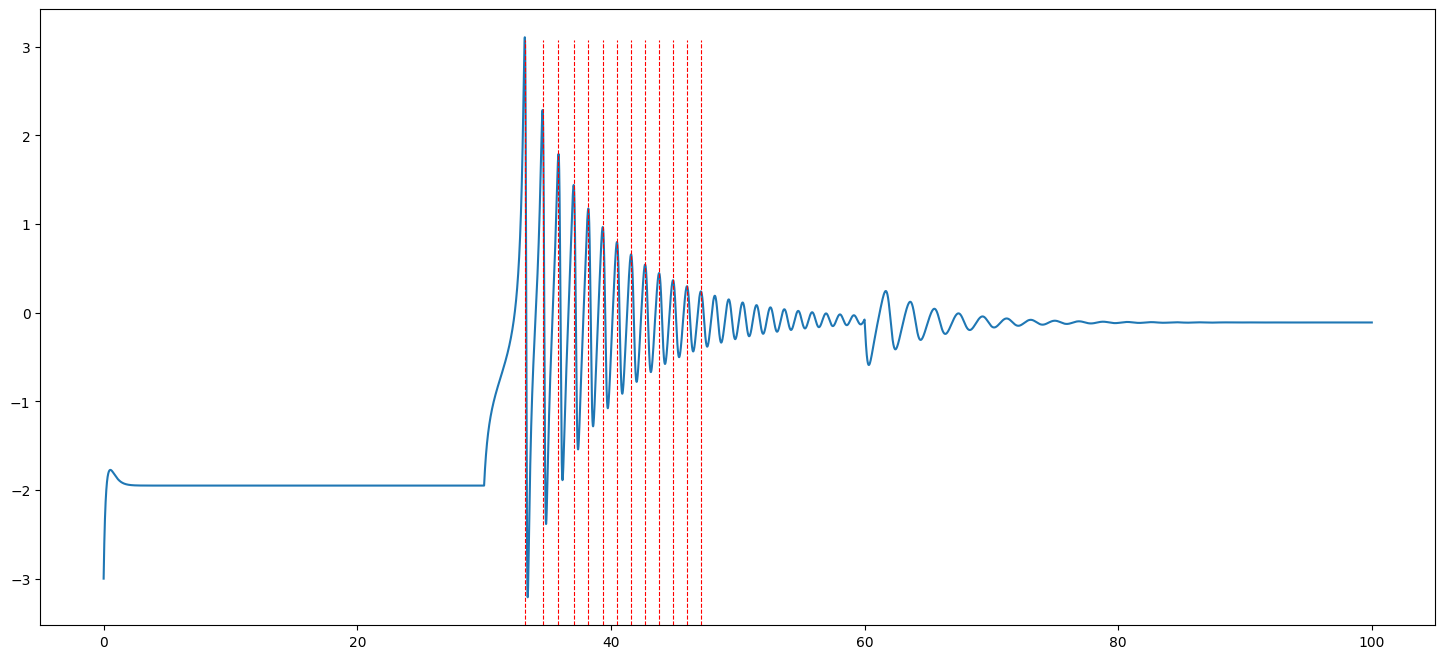

In [26]:
plt.figure(figsize=(18, 8))
plt.plot(ts,v)
for i in np.r_[0:len(peaks_act)]:
     plt.axvline(x=t_on+dt*peaks_act[i], ymin=0, ymax=0.95, linewidth=.8, color = 'r', linestyle='--')
plt.show()

In this notebook we use this function to calculate summary statistics and (mean, std, median, skew, kurtosis) in three segmeents, in addition to the first peaks and the number of peaks in the entire time series, which in total returns 17 elements for each time series.

In [27]:
from MPR_NMM_sumstats import calculate_summary_statistics

In [28]:
_=calculate_summary_statistics(v, dt, ts, t_on, t_off)
_.shape

(17,)

In [29]:
_

array([-1.94862515e+00,  4.94874504e-02, -1.95036874e+00, -1.08410045e+01,
        1.86733085e+02, -1.24185576e-01,  6.94910192e-01, -1.01817910e-01,
        1.13177559e-01,  4.12548604e+00, -1.14703068e-01,  8.48519127e-02,
       -1.10529037e-01, -1.13297893e+00,  1.03623192e+01,  1.30000000e+01,
        3.32090000e+01])

To make Bayesian SBI, we need three elements:

1) Simulator that takes parameters as input and returns data features as output.

2) Prior, which defines the plausible range based on the background knowledge, to draw random samples for parameters, as the input to simulator.

3) Inference step on observed data, which we train a deep neural density estimator on data features and approximate posterior for the set of observed data.


## 1. Simulator


The wrapper takes only parameters as the input and return the features (summary statistics) or raw time series as the output, the later case if we like to save the simulations and then load them and calculate the corresponding features.

In [30]:
def Montbrio_ODEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    rv = Montbrio_ODEmodel_numba(params, constants, I_input, dt, ts)
    v=rv[0:nt]
    
    #summstats = torch.as_tensor(calculate_summary_statistics(v.reshape(-1), dt, ts, t_on, t_off))
    
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),)) 

Sanity check:

In [31]:
params_=[0.7, -4.6, 14.5]

Montbrio_ODEmodel_Wrapper(params_).shape

(200000,)

## 2. Prior over model parameters


In [32]:
prior_min = [0.1, -10., 5.0]
prior_max = [5.0, -3.0, 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [33]:
# an examle of stacking the priors with diferent sizes
#prior_min_G=0.0*np.ones(1)
#prior_max_G=1.0*np.ones(1)

#prior_min_mu=-0.11*np.ones(n_compt)
#prior_max_mu=0.005*np.ones(n_compt)

#prior_min=np.hstack([prior_min_G, prior_min_mu])
#prior_max=np.hstack([prior_max_G, prior_max_mu])

#prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [34]:
prior.sample()

tensor([ 4.5732, -4.7764,  7.0106])

In [35]:
num_params=prior.sample().shape[0]
num_params

3

In [36]:
prior_samples=np.stack([prior.sample().tolist() for _ in range(1000)], axis=0)
prior_samples.shape

(1000, 3)

### 3. Inference

Now we run the inferece step. To do so, we run a budget of random simulations; for each the data feature is calculated, and then an algorithm such as SNPE learns the relationship between the data features and paranateners of an approximated posterior.

In [37]:
# # 1-step approach: online simualtion, calculation of features, and inference

# start_time = time.time()

# posterior = infer(Montbrio_ODEmodel_Wrapper, prior, method='SNPE', num_simulations=50000, num_workers=1)

# print ("-"*60)
# print("--- %s seconds ---" % (time.time() - start_time))

### save simulations

Since running a large number of simulations is computationally expensive, we save the simulations generated from a random sampling of parameters through prior. This allows us to perform ad-hoc inference on the simulations to investigate the role of different features without re-simulation (amortized at subject level). But Note that saving the simuations and loading them needs much more space and memory.

In [38]:
#this is the budget of our simulation for training SNPE with a single of round to benifit from amortized strategy; it means with train once, and then we can fit any data we wish without re-training.

num_sims=10000


In [39]:
try:
    os.mkdir(cwd+'/output_simulations')
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

In [40]:
mysavepath = os.path.join(cwd, 'output_simulations/simulated_theta_x_MPR_ode.npz')
mysavepath

'/mnt/0582b5ea-dc43-4c17-8a69-29b39f3fc394/SBI/MPR_NMM_SBI/output_simulations/simulated_theta_x_MPR_ode.npz'

In [41]:
def Save_simulations(simulator: Callable, prior, mysavepath, num_simulations: int):

    simulator, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(simulator=simulator,
                                proposal=prior,
                                num_simulations=num_simulations,
                                show_progress_bar=True,)

    print( 'theta shape:',theta.shape,flush=True)
    print('data shape:', x.shape,flush=True)

    np.savez(mysavepath,theta=theta,x=x)

Since we place our simulator in another function, we need to run it for one simulation, for later beneficiation of JIT. In the saving step, the parameters are referred to as the vector theta, and the simulated signals as $x$ reshaped to vector (dimention will be $nn \times nt$). Finnaly, their dimention are: $theta \in [n_{sim} , n_{params}]$, and $ x \in [n_{sim},  nn \times nt] $. Here we save the activity of both r and v, so at the end nn=2.


In [42]:
start_time = time.time()

Save_simulations(Montbrio_ODEmodel_Wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one simulation took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 3])
data shape: torch.Size([1, 200000])
------------------------------------------------------------
--- one simulation took: 1.6583313941955566 seconds ---


In [43]:
start_time = time.time()

Save_simulations(Montbrio_ODEmodel_Wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one simulation with JIT took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 3])
data shape: torch.Size([1, 200000])
------------------------------------------------------------
--- one simulation with JIT took: 0.03782057762145996 seconds ---


In [44]:
start_time = time.time()

Save_simulations(Montbrio_ODEmodel_Wrapper, prior, mysavepath, num_simulations=num_sims)

print ("-"*60)
print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

theta shape: torch.Size([10000, 3])
data shape: torch.Size([10000, 200000])
------------------------------------------------------------
---all simulations took:  144.0868799686432 seconds ---


### Load simulations and calculate features

In [45]:
loaded_simulations=np.load(mysavepath)

In [46]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [47]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (10000, 3)
data shape: (10000, 200000)


In [48]:
x_sim[0,:].shape

(200000,)

In [49]:
if np.isfinite(np.sum(x_sim[0,:]))==True:
    v_sim=x_sim[0,:][0:nt]
    _=calculate_summary_statistics(v_sim.reshape(-1), dt, ts, t_on, t_off)
    _.shape

num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 17


Now we are ready to provide the inputs as random sampled theta from prior (the set of parameters we aim to infer) and the features of observation x for inference (in torch tensor format). Given parameter $\theta$ and observation $x$, we can then sample from the posterior $p(\theta|x)$, evaluate its log-probability, or plot it. 

The dimention of theta is [number_simulations $\times$ number_parameters] and x is [number_simulations $\times$ number_features].

At the moments, SBI works only with float32.

In [50]:
theta_features=np.zeros((num_sims,num_params))
x_features=np.zeros((num_sims,num_features))

In [51]:
print( 'theta shape:',theta_features.shape,flush=True)
print('data frature shape:', x_features.shape,flush=True)

theta shape: (10000, 3)
data frature shape: (10000, 17)


In [52]:
start_time = time.time()

i = 0
for i in range(num_sims):
       v_sim=x_sim[i,:][0:nt]
       if np.isfinite(np.sum(v_sim))==True:
              theta_features[i,:]=theta_sim[i,:] 
              x_features[i,:]=calculate_summary_statistics(v_sim.reshape(-1), dt, ts, t_on, t_off)
       i += 1
    
print ("-"*60)
print("--- Calculating features took: %s seconds ---" % (time.time() - start_time))    

------------------------------------------------------------
--- Calculating features took: 52.907209396362305 seconds ---


We now load remove the nans and make them in float32 and rename it to again theta, and x.

In [53]:
theta_features.shape, x_features.shape,

((10000, 3), (10000, 17))

In [54]:
print(theta_features.dtype), print(x_features.dtype)

float64
float64


(None, None)

In [55]:
index = np.isnan(x_sim).any(axis=1)
np.count_nonzero(index)

0

In [56]:
x_features = np.delete(x_features, index, axis=0)
theta_features=np.delete(theta_features, index, axis=0)

In [57]:
theta_features.shape, x_features.shape

((10000, 3), (10000, 17))

In [58]:
print(theta_features.dtype), print(x_features.dtype)

float64
float64


(None, None)

In [59]:
x = np.array(x_features, dtype='float32')
x = torch.as_tensor(x)

theta = np.array(theta_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)

In [60]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([10000, 3])
data feature shape: torch.Size([10000, 17])


In [61]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([10000, 3])
data feature shape: torch.Size([10000, 17])


In [62]:
numpy.isnan(x).any()

tensor(0, dtype=torch.uint8)

In [63]:
numpy.isfinite(x).all()

tensor(1, dtype=torch.uint8)

Finally we use Sequential Neural Posterior Estimation (SNPE) to sample from the posterior $p(\theta|x)$. The inputs are prior, parameter theta and (the data features of) observation x, and it returns us the posterior $p(\theta|x)$.

In [64]:
inference = SNPE(prior, density_estimator='maf', device='cpu')

In [65]:
start_time = time.time()

posterior_estimator = inference.append_simulations(theta, x).train()

print ("-"*60)
print("---training took:  %s seconds ---" % (time.time() - start_time))

 Neural network successfully converged after 165 epochs.------------------------------------------------------------
---training took:  304.22122716903687 seconds ---


In [66]:
## Without the saving and loading simulations, we can run sbi using the default function "infer", as follows:
##posterior = infer(simulator_wrapper, prior, method='SNPE',  num_simulations=num_sim, num_workers=1)

### Observed Data

In [67]:
params_label=np.array(['$\Delta$', '$\eta$', '$J$'])

In [68]:
delta_true=0.7
eta_true=-4.6
J_true=14.5

true_params = np.array([delta_true, eta_true, J_true])

In [69]:
x_obs= Montbrio_ODEmodel_numba(true_params, constants, I_input, dt, ts)
v_obs=x_obs[0:nt]
r_obs=x_obs[nt:2*nt]
x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), dt, ts, t_on, t_off)

In [70]:
x_obs_summary_statistics.shape

(17,)

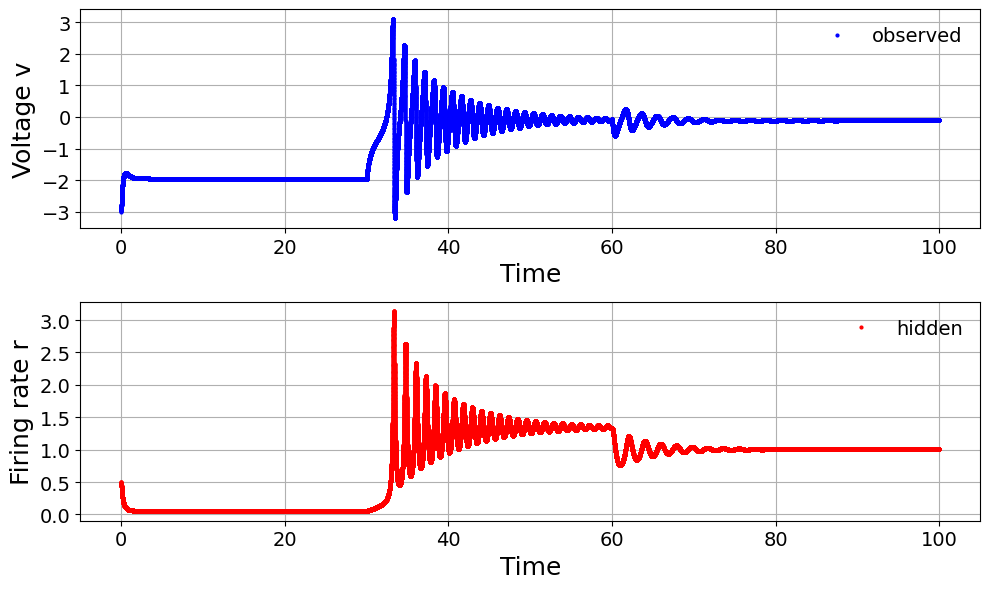

In [71]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_obsI.png"), dpi=300)
plt.show()

### Posterior sampling

No we sample from joint posterior given the data features of observed data. Note that this should be the exact dimension as we trained the SNPE (in this notebook 17 elements in data features). The sampling is fast, so it does not matter we take 1k or 10k samples from posterior. The dimention of posterior will be: (number of samples, number of parameters).

In [72]:
num_samples=10000

In [73]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [74]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

print ("-"*60)
print("--- posterior sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

------------------------------------------------------------
--- posterior sampling took: 0.07449626922607422 seconds ---


In [75]:
np.save(os.path.join(cwd, 'posterior_samples_obsI.npy') , posterior_samples)

In [76]:
delta_est=posterior_samples[:,0]
eta_est=posterior_samples[:,1]
J_est=posterior_samples[:,2]

In [77]:
print("delta_est=", delta_est.mean())
print("eta_est=", eta_est.mean())
print("J_est=", J_est.mean())

delta_est= 0.734036
eta_est= -4.6289096
J_est= 14.693703


Now we use the violin plot for visualization; the red is the ground truth that we used to generate the observed data. Ideally, the posterior is centered around the ground-truth if not multimodal, with proper value of shrinkages. Genrally speaking, the more number of simulations and more informative data features will provide the more posterior shrinkage (but there will a limit for this, as we do not expect to get the posatrior as a delta dirac!!!).

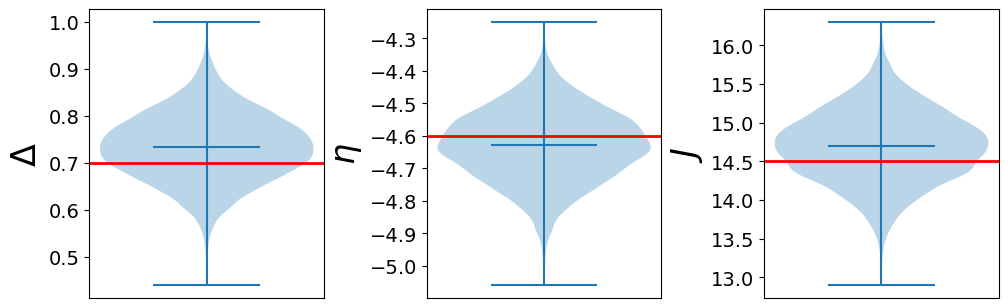

In [78]:
plt.figure(figsize=(10, 3))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_ode_Istep_EstimatedParams_obs.png"), dpi=300)
plt.show()

And here a KDE on the SBI posterior, and their MAP estimations (in cyan color).  

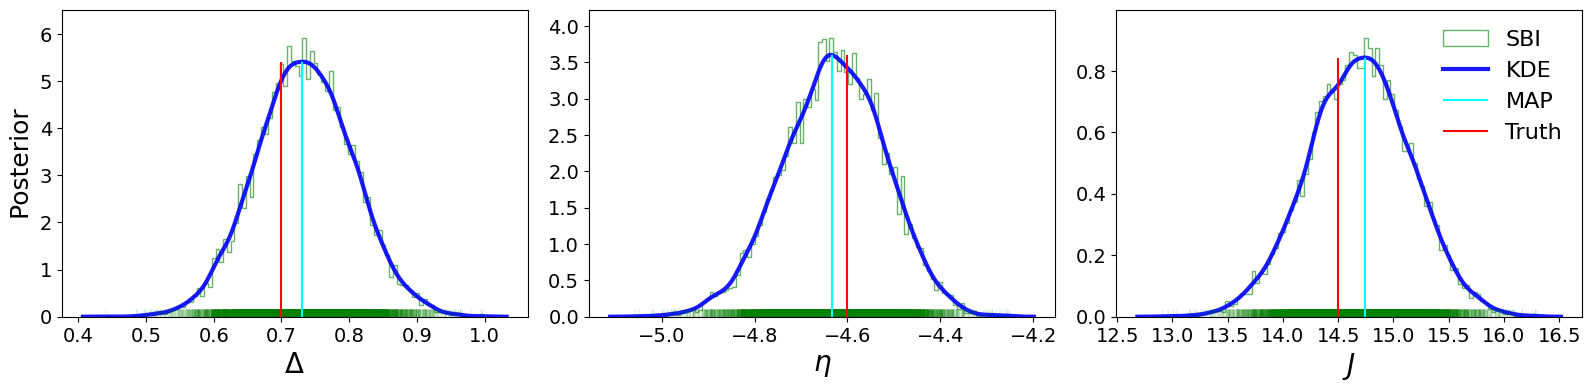

In [79]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_Istep_EstimatedParams_obsI.png"), dpi=300)
plt.show()

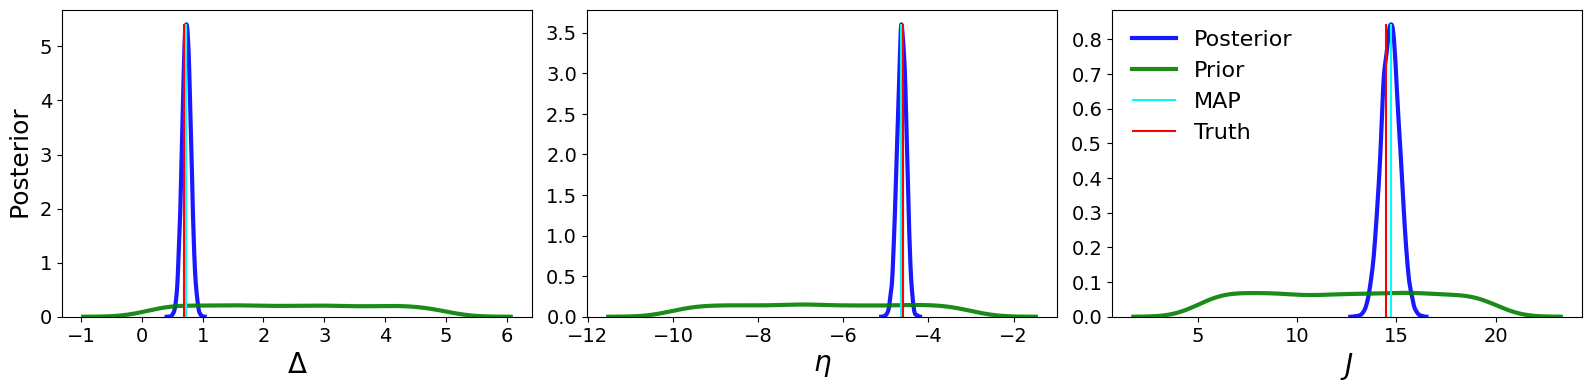

In [80]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    
   
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "Posterior"})
    
    ax_=sns.distplot(prior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "g", "alpha": 0.9, "lw": 3, "label": "Prior"})

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_Istep_EstimatedParamswithPrior_obsI.png"), dpi=300)
plt.show()

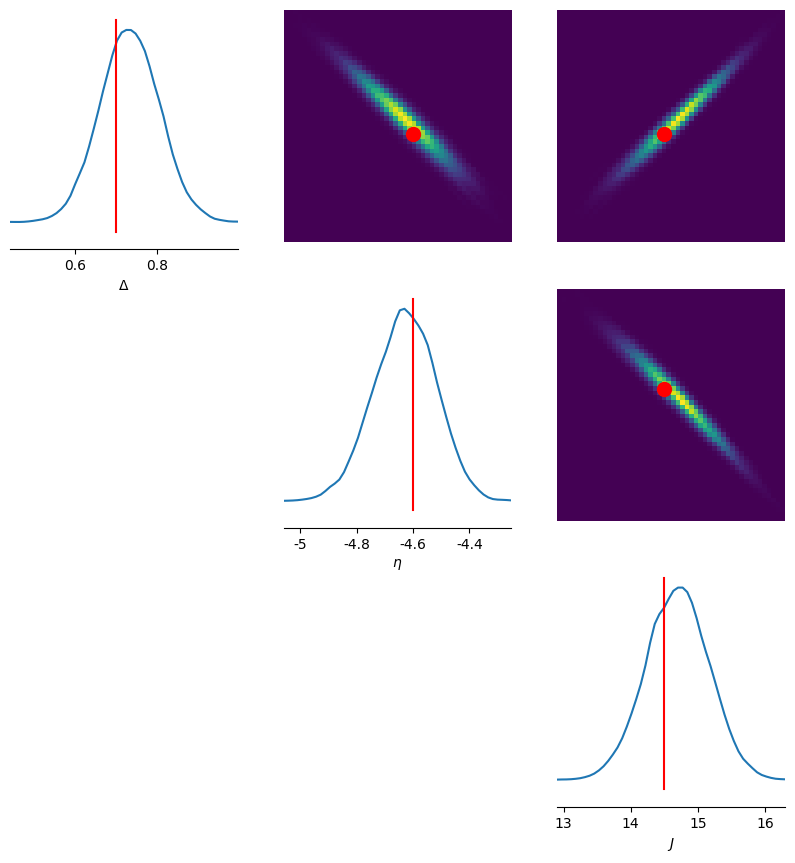

In [81]:
fig, axes = pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=params_label,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_posterior_pairplot_obsI.png"), dpi=300)
plt.show()

Here by the scatter plot of joint posterior we see a high linear relationship between parameters eta and J, which can be imporoved by including the feature of firing rate (directly, or indirectly using time-delay embedding to reconstruct full state-space representation).

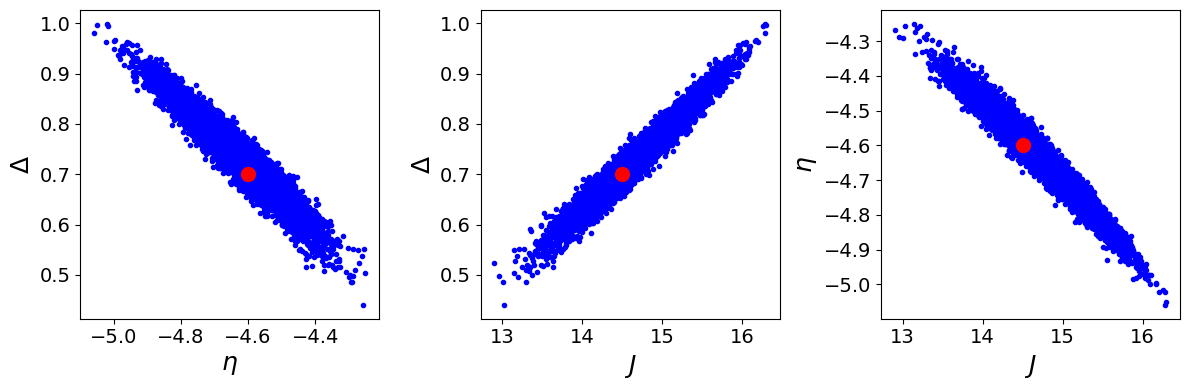

In [82]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(eta_est, delta_est,'.', color='blue')
plt.plot(eta_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$\eta$", fontsize=18)
plt.ylabel("$\Delta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(132)
plt.plot(J_est, delta_est, '.',color='blue')
plt.plot(J_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$J$", fontsize=18)
plt.ylabel("$\Delta$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(133)
plt.plot(J_est, eta_est, '.', color='blue')
plt.plot(J_true, eta_true, 'o', color='red', markersize=10)
plt.xlabel("$J$", fontsize=18)
plt.ylabel("$\eta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_posterior_PairParamsJoindist_obsI.png"), dpi=300)
plt.show()

In [83]:
delta_est=array([delta_est]).T
eta_est=array([eta_est]).T
J_est=array([J_est]).T

In [84]:
params = {'delta_est': delta_est, 'eta_est': eta_est, 'J_est': J_est}
        
f=concatenate((delta_est, eta_est, J_est), axis=1)

df = pd.DataFrame(f, columns=['delta_est',  'eta_est', 'J_est' ])

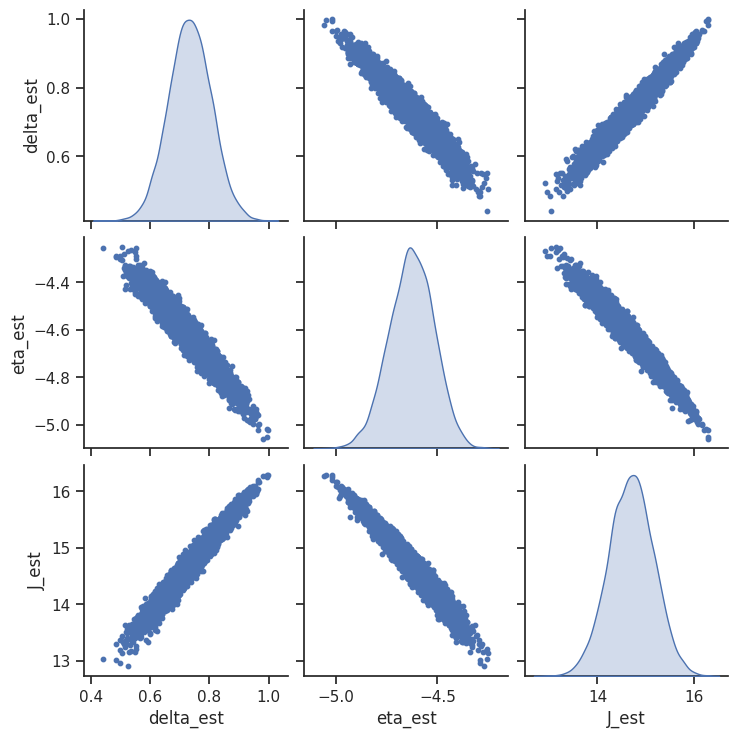

In [85]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df, diag_kind="kde", markers="o",plot_kws=dict(s=10, edgecolor="b", linewidth=1))
#g.set(xticklabels=[])
#g.set(yticklabels=[])

In [86]:
df.corr()

,delta_est,eta_est,J_est
delta_est,1.000000,-0.958998,0.974519
eta_est,-0.958998,1.000000,-0.974055
J_est,0.974519,-0.974055,1.000000


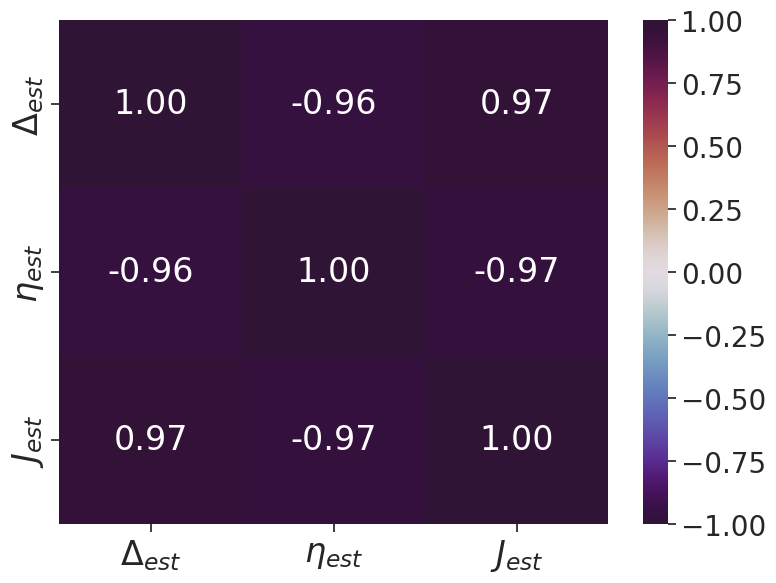

In [87]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(df.corr(), annot=True, robust=True, cmap='twilight_shifted', linewidths=.0, annot_kws={'size':24}, fmt=".2f", vmin=-1, vmax=1, ax=ax, xticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ], yticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ])
#ax.set_xticklabels()
#ax.set_yticklabels()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.tick_params(labelsize=24)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_posterior_CorrParams_obsI.png"), dpi=300)
plt.show()

Now we make posterior predictive check to see how is close the re-simuation from MAP is close to the observed data i.e., posterior predictive check (ppc).

In [88]:
x_fit= Montbrio_ODEmodel_numba(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, I_input, dt, ts)
v_fit=x_fit[0:nt]
r_fit=x_fit[nt:2*nt]

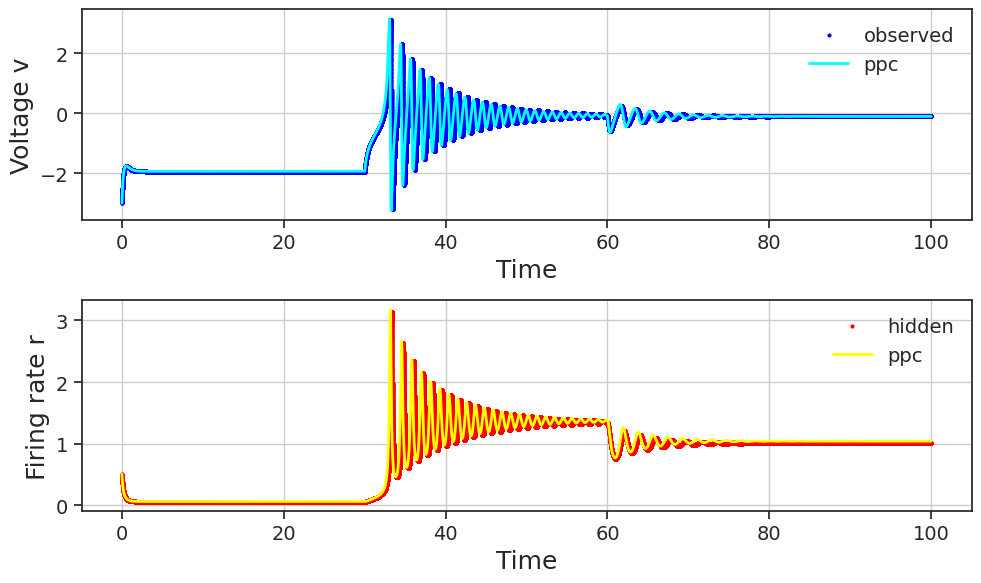

In [89]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.plot(ts, v_fit, lw=2, color='cyan', label='ppc')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.plot(ts, r_fit, lw=2, color='yellow', label='ppc')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_fit_obsI.png"), dpi=300)
plt.show()

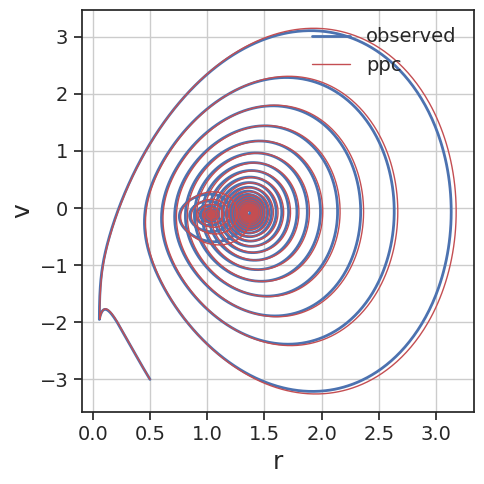

In [90]:
plt.figure(figsize=(5, 5))
plt.plot(r_obs, v_obs, 'b', linewidth=2, label='observed')
plt.plot(r_fit, v_fit, 'r', linewidth=1, label='ppc')
plt.ylabel('v', fontsize=18); 
plt.xlabel('r', fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_fitphaseplane_obsI.png"), dpi=300)
plt.show()

In [91]:
sensitivity = ActiveSubspace(posterior.set_default_x(x_obs_summary_statistics))
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [92]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([6.3096e-05, 8.8156e-03, 9.9944e-03]) 

Eigenvectors: 
 tensor([[-0.3882,  0.2296, -0.8925],
        [ 0.4210,  0.9057,  0.0499],
        [-0.8198,  0.3564,  0.4483]])


In [93]:
sensitivity_vals = pd.Series(1/e_vals, index=params_label)

df = pd.DataFrame({'sensitivity_vals' : sensitivity_vals})
df = df.sort_values(by='sensitivity_vals')
normalized_df=(df-df.min())/(df.max()-df.min())
my_range=list(range(1,len(df.index)+1))


In [94]:
normalized_df

,sensitivity_vals
$J$,0.00000
$\eta$,0.00085
$\Delta$,1.00000


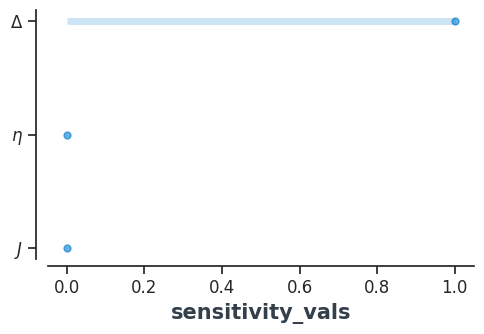

In [95]:
fig, ax = plt.subplots(figsize=(5,3.5))

plt.hlines(y=my_range, xmin=0, xmax=normalized_df, color='#007ACC', alpha=0.2, linewidth=5)
plt.plot(normalized_df, my_range, "o", markersize=5, color='#007ACC', alpha=0.6)
plt.yticks(my_range, df.index)
ax.set_xlabel('sensitivity_vals', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(0,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obsI.png"), dpi=300)
plt.show()

In [96]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'true_params_ode_Vfeatures100k_obsI.npy'), true_params)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'posterior_samples_ode_Vfeatures100k_obsI.npy'), posterior_samples)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'x_obs_ode_Vfeatures100k_obsI.npy'), x_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'x_fit_ode_Vfeatures100k_obsI.npy'), x_fit)

Since the SNPE with a single round of training is amortized, we can infer the parameters from any new observation. Lets try it! 

###  Observed Data II

This is another set of observed data that we aim to fit.

In [97]:
delta_true=0.4
eta_true=-4.
J_true=18.5

true_params = np.array([delta_true, eta_true, J_true])

In [98]:
x_obs= Montbrio_ODEmodel_numba(true_params, constants, I_input, dt, ts)
v_obs=x_obs[0:nt]
r_obs=x_obs[nt:2*nt]
x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), dt, ts, t_on, t_off)

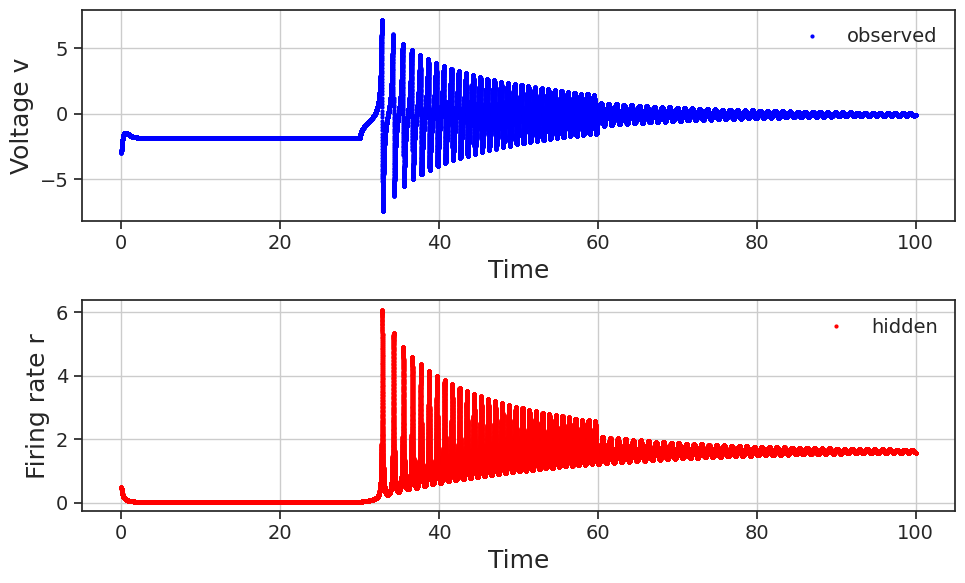

In [99]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_obsII.png"), dpi=300)
plt.show()

### Posterior II

In [100]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

print ("-"*60)
print("--- posterior sampling took: %s seconds ---" % (time.time() - start_time))


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

------------------------------------------------------------
--- posterior sampling took: 0.09601736068725586 seconds ---


In [101]:
delta_est=posterior_samples[:,0]
eta_est=posterior_samples[:,1]
J_est=posterior_samples[:,2]

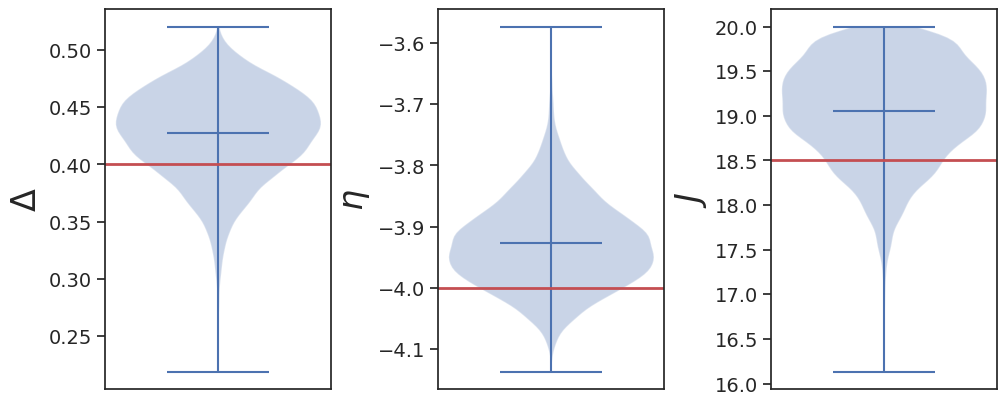

In [102]:
plt.figure(figsize=(10, 4))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_ode_Istep_EstimatedParams_obsII.png"), dpi=300)
plt.show()

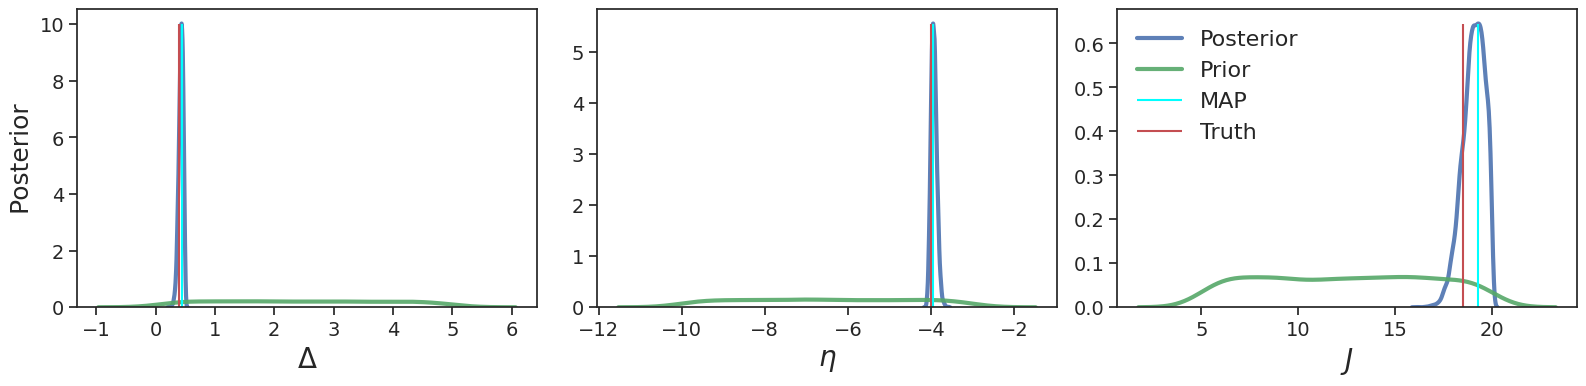

In [103]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    
   
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "Posterior"})
    
    ax_=sns.distplot(prior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "g", "alpha": 0.9, "lw": 3, "label": "Prior"})

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_Istep_EstimatedParamswithPrior_obsII.png"), dpi=300)
plt.show()

In [104]:
x_fit= Montbrio_ODEmodel_numba(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, I_input, dt, ts)
v_fit=x_fit[0:nt]
r_fit=x_fit[nt:2*nt]

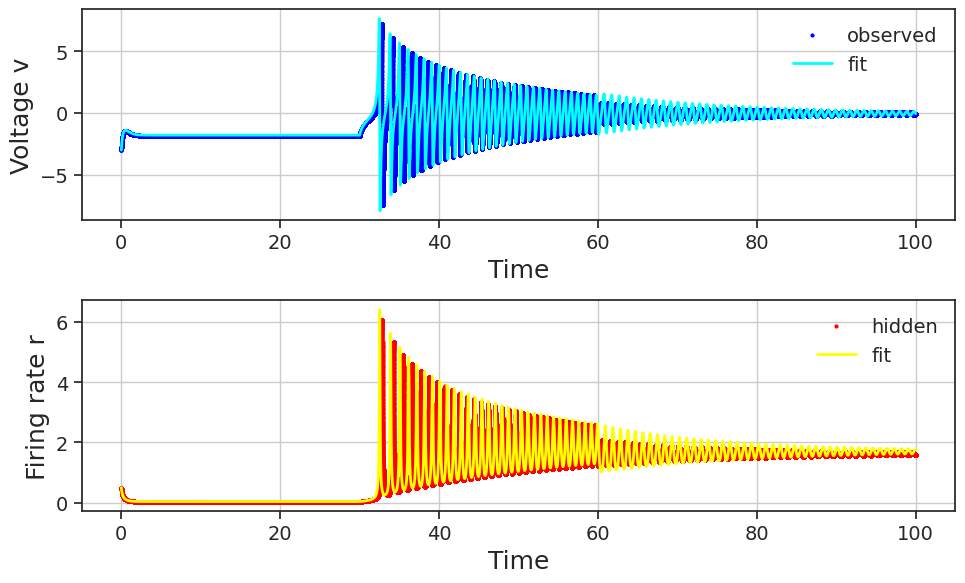

In [105]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.plot(ts, v_fit, lw=2, color='cyan', label='fit')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.plot(ts, r_fit, lw=2, color='yellow', label='fit')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_fit_obsII.png"), dpi=300)
plt.show()

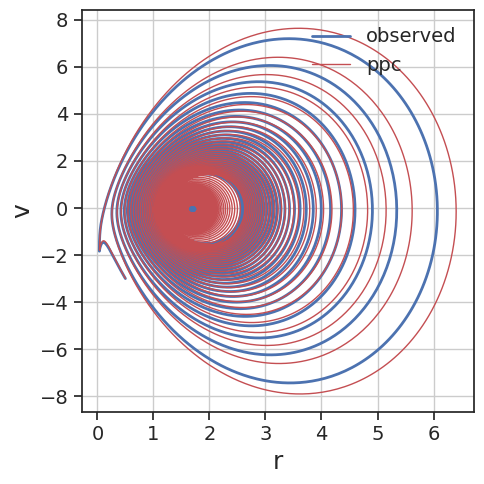

In [106]:
plt.figure(figsize=(5, 5))
plt.plot(r_obs, v_obs, 'b', linewidth=2, label='observed')
plt.plot(r_fit, v_fit, 'r', linewidth=1, label='ppc')
plt.ylabel('v', fontsize=18); 
plt.xlabel('r', fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_fitphaseplane_obsII.png"), dpi=300)
plt.show()

###  Observed Data III

In [107]:
delta_true=1.5
eta_true=-5.
J_true=10.

true_params = np.array([delta_true, eta_true, J_true])

In [108]:
x_obs= Montbrio_ODEmodel_numba(true_params, constants, I_input, dt, ts)
v_obs=x_obs[0:nt]
r_obs=x_obs[nt:2*nt]
x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), dt, ts, t_on, t_off)

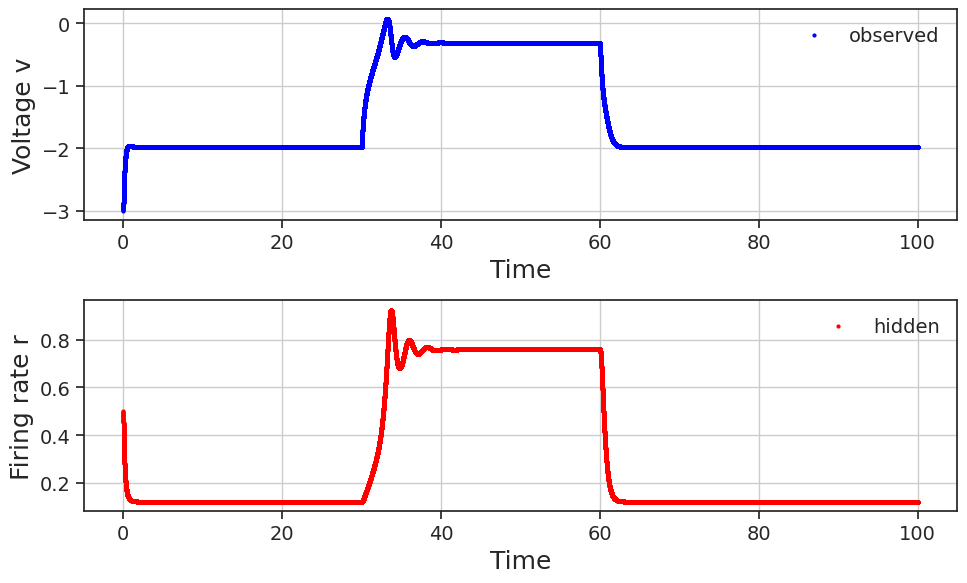

In [109]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_obsIII.png"), dpi=300)
plt.show()

### Posterior III

In [110]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

print ("-"*60)
print("--- posterior sampling took: %s seconds ---" % (time.time() - start_time))


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

------------------------------------------------------------
--- posterior sampling took: 0.07490324974060059 seconds ---


In [111]:
delta_est=posterior_samples[:,0]
eta_est=posterior_samples[:,1]
J_est=posterior_samples[:,2]

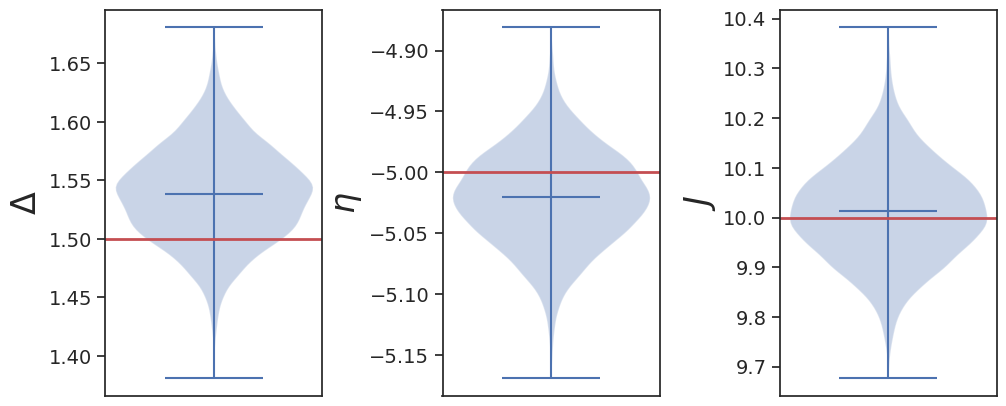

In [112]:
plt.figure(figsize=(10, 4))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_ode_Istep_EstimatedParams_obsII.png"), dpi=300)
plt.show()

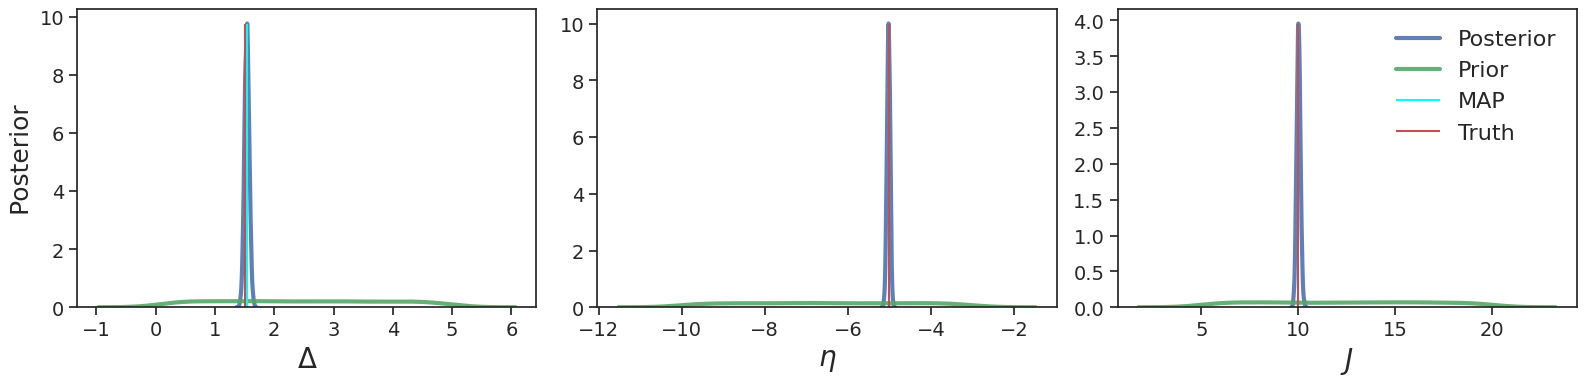

In [113]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    
   
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "Posterior"})
    
    ax_=sns.distplot(prior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "g", "alpha": 0.9, "lw": 3, "label": "Prior"})

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_Isin_EstimatedParamswithPrior_obsIII.png"), dpi=300)
plt.show()

In [114]:
x_fit= Montbrio_ODEmodel_numba(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, I_input, dt, ts)
v_fit=x_fit[0:nt]
r_fit=x_fit[nt:2*nt]

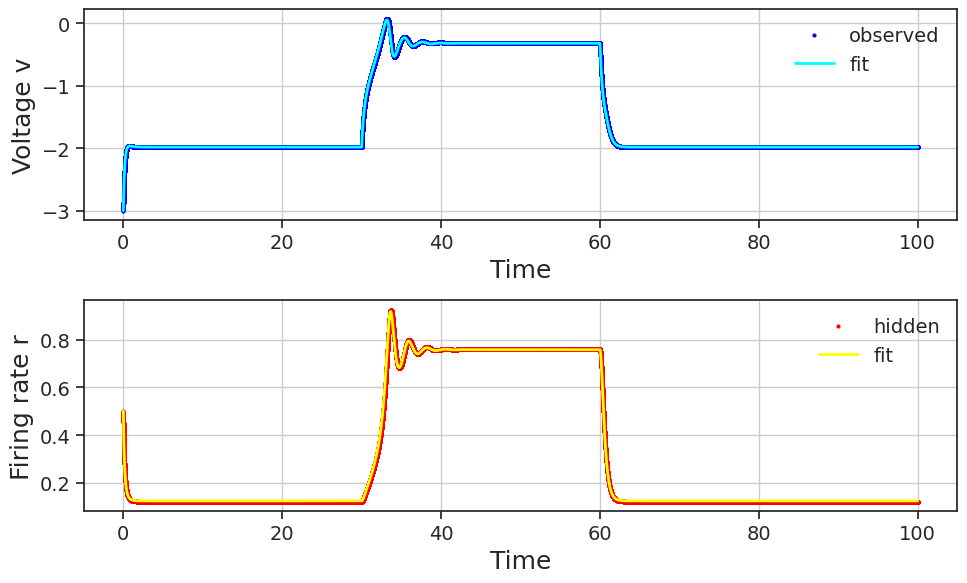

In [115]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.plot(ts, v_fit, lw=2, color='cyan', label='fit')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.plot(ts, r_fit, lw=2, color='yellow', label='fit')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_fit_obsIII.png"), dpi=300)
plt.show()

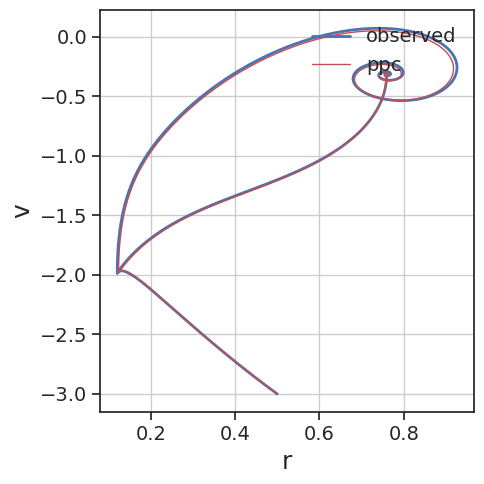

In [116]:
plt.figure(figsize=(5, 5))
plt.plot(r_obs, v_obs, 'b', linewidth=2, label='observed')
plt.plot(r_fit, v_fit, 'r', linewidth=1, label='ppc')
plt.ylabel('v', fontsize=18); 
plt.xlabel('r', fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep_fitphaseplane_obsIII.png"), dpi=300)
plt.show()

To do: make more effieicnt way of saving (less space), and loading (less memory).